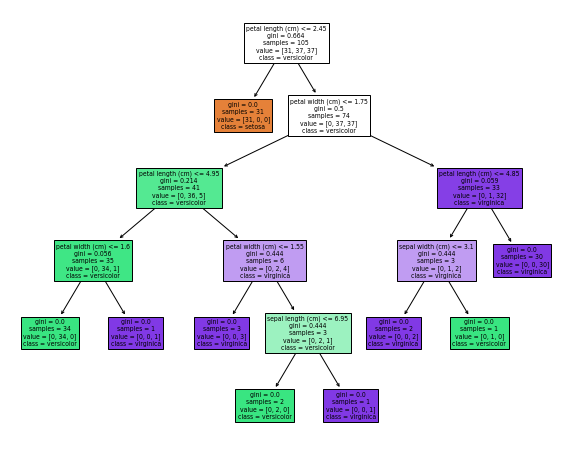

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

# Create a Decision Tree classifier with max depth of 3
dtree = DecisionTreeClassifier()

# Train the classifier on the training set
dtree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(10,8))
plot_tree(dtree, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()


In [ ]:
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import date
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.corpus import words
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import shap

In [ ]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# Add the json file format for credentials
creds = ServiceAccountCredentials.from_json_keyfile_name(r'C:\Users\vamsi\GSA_LinkedIn_WebScrapping\new_project_scraping\ucdavismsba-174d7e753d10.json', scope)

# authorize the clientsheet
client = gspread.authorize(creds)

sheet_key = '17vIVA7djuT0A9PHlxLT53_kib0Yquv3UhkTIOQo_lLY'

# open a google sheet
gs = client.open_by_key(sheet_key)

worksheet = gs.worksheet('jobs')

In [ ]:
df_jobs = get_as_dataframe(worksheet=worksheet)

In [ ]:
pd.set_option("display.max_colwidth",50000)

In [ ]:
df_jobs.drop_duplicates(subset=['job_description'],inplace=True)

In [ ]:
df_jobs.shape

(255, 19)

In [ ]:
df_jobs['qualification'].head(1)

0    Bachelor's Degree in Computer Science or a directly related field is required (4 years' experience can be considered in lieu of degree).10+ years of experience with a strong background in artificial intelligence and machine learning. Experience with AI/ML is a must with implementations using languages such as .NET and Python or Java.Familiar with AI/ML tooling, useful models and frameworks, and the ability to share knowledge across teams.Experience at model training, implementation and deployment.
Name: qualification, dtype: object

In [ ]:
def text_prep(jd):
    jd = re.sub("[^a-zA-Z]", " ", jd)
    words_to_remove = ['business analyst','data', 'data scientist', 'science','analyst', 'scientist','scientists','data analyst','business','data science','machine learning','machine']
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', flags=re.IGNORECASE)
    jd = pattern.sub('', jd)
    return jd

In [ ]:
df_jobs['cleaned_text'] = df_jobs['job_description'].apply(lambda x: text_prep(x))

In [ ]:
le = preprocessing.LabelEncoder()
y=le.fit_transform(df_jobs['job_role_input'])

In [ ]:
df_train, df_test, y_train, y_test = train_test_split(df_jobs['cleaned_text'], y, test_size=0.20, random_state=42,stratify=y)

In [ ]:
tv = TfidfVectorizer(
                    ngram_range = (1,3),
                    sublinear_tf = True,
                    lowercase=True,
                    stop_words='english',
                    min_df=0.1)

In [ ]:
train_tv = tv.fit_transform(df_train)
test_tv = tv.transform(df_test)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_tv, y_train)

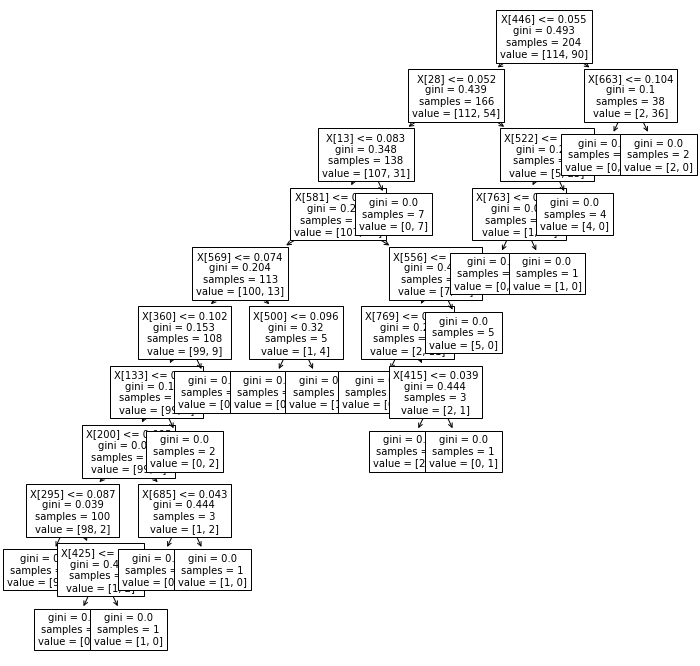

In [ ]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

In [ ]:
#!pip install graphviz
import graphviz

In [ ]:
tree.export_graphviz(clf,
                      feature_names=tv.get_feature_names_out,
                      class_names=le.classes_
                     )

TypeError: object of type 'method' has no len()

In [ ]:

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=tv.get_feature_names_out,
                      class_names=le.classes_,
                     filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

TypeError: object of type 'method' has no len()

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0,oob_score=True)
clf.fit(train_tv, y_train)

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

In [ ]:
clf.oob_score_

0.8823529411764706

In [ ]:
y_pred = clf.predict(test_tv)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

array([[26,  3],
       [ 6, 16]], dtype=int64)

In [ ]:
importances = clf.feature_importances_

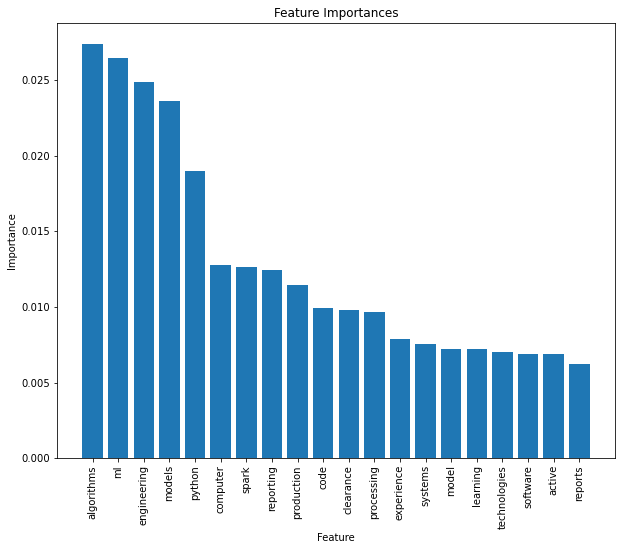

In [ ]:
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar chart of feature importances
plt.figure(figsize=(10,8))
plt.bar(range(20), importances[indices][:20])

# Add feature names as x-axis labels
plt.xticks(range(20), [tv.get_feature_names_out()[i] for i in indices][:20], rotation=90)

# Set axis labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
le.classes_[0]

'Data Analyst'

Data Analyst


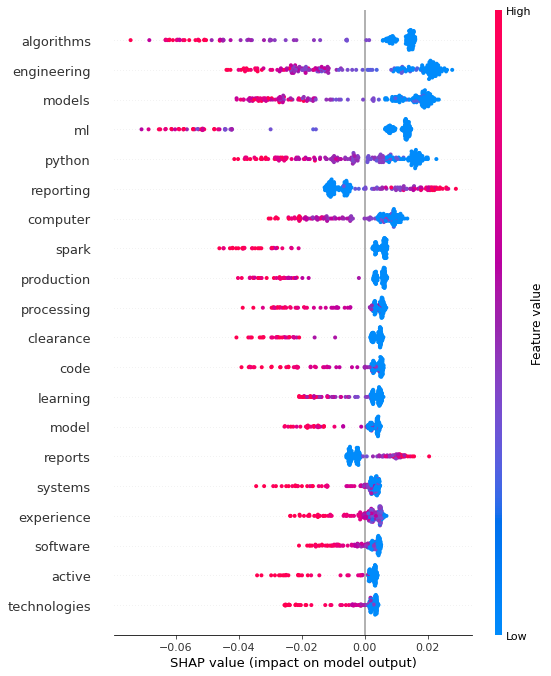

Data Scientist


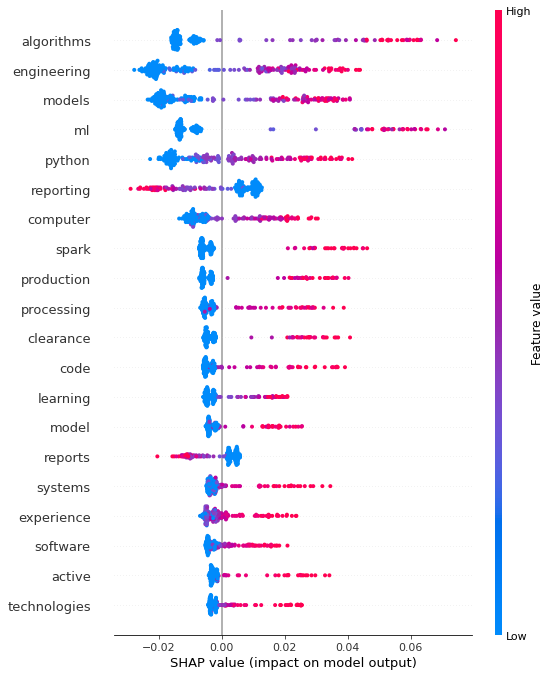

In [ ]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(train_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(train_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())

Data Analyst


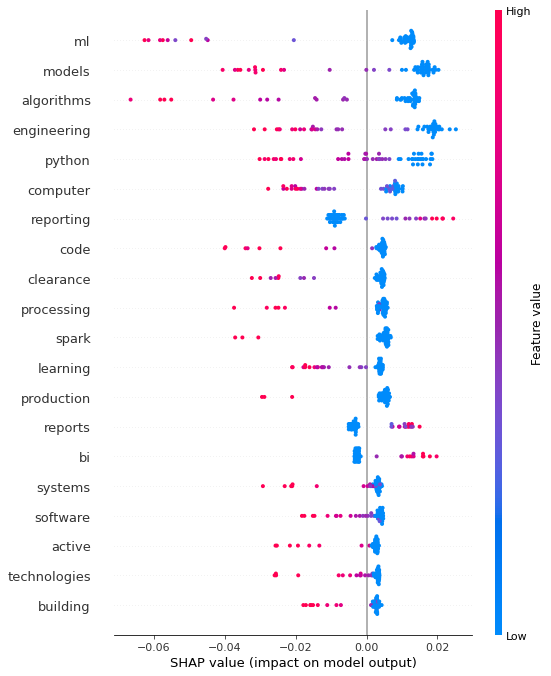

Data Scientist


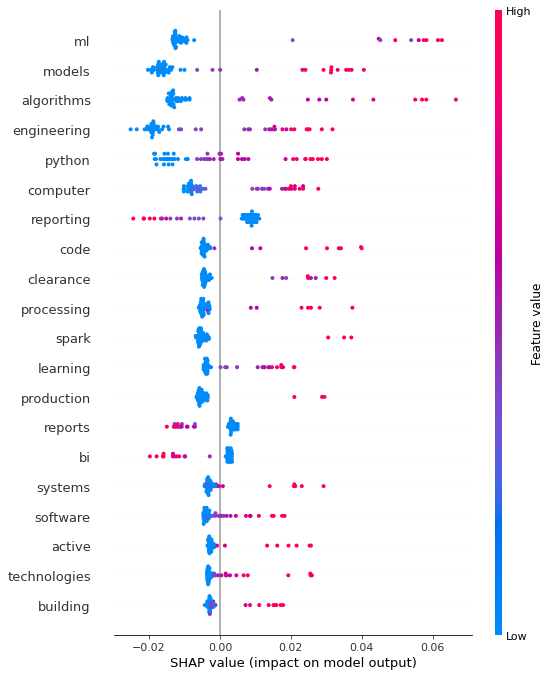

In [ ]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(test_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(test_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())

In [ ]:
# Calculate the feature importance for each class
class_0_importance = np.abs(shap_values[0]).mean(axis=0)
class_1_importance = np.abs(shap_values[1]).mean(axis=0)
#class_2_importance = np.abs(shap_values[2]).mean(axis=0)

# Print the feature importance for each class
print('Class 0 Feature Importance:')
for feature, importance in zip(tv.get_feature_names_out(), class_0_importance):
    print(f'{feature}: {importance}')

print('\nClass 1 Feature Importance:')
for feature, importance in zip(tv.get_feature_names_out(), class_1_importance):
    print(f'{feature}: {importance}')

Class 0 Feature Importance:
abilities: 5.18958558736226e-05
ability: 0.00033516984827724073
ability work: 0.0005759664401032534
able: 0.0002652593517119156
access: 0.00022516754162363024
accommodation: 0.0004671171755417645
accommodations: 0.0002841998428137764
accuracy: 0.0007146144830160527
accurate: 0.00013928877199542066
achieve: 0.0001043861092398836
act: 9.096649270440865e-05
action: 0.0002481050462603819
actionable: 6.241552814058123e-05
active: 0.004666793801357516
activities: 4.98448798434613e-05
actual: 0.00014012981989044467
ad: 0.00034397714613293765
ad hoc: 0.00013959110759405966
addition: 0.00025826674346284776
additional: 0.0006222627331193109
address: 5.523298657036248e-05
advanced: 0.0010198352854991855
affirmative: 0.0007731300174241061
affirmative action: 0.0008142499743256872
age: 0.001328849115300497
agencies: 4.93970397703076e-05
agile: 0.0022902143353714086
ai: 0.0024037931123624657
algorithms: 0.0179634025206893
analyses: 0.0017151868987407455
analysis: 0.004425

### Count Vectorizer

In [ ]:
cv = CountVectorizer(
                    ngram_range = (1,3),
                    lowercase=True,
                    stop_words='english',
                    max_df=0.8,
                    min_df=0.1,
                    max_features = 4000)

In [ ]:
train_tv = cv.fit_transform(df_train)
test_tv = cv.transform(df_test)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0,oob_score=True)
clf.fit(train_tv, y_train)

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

In [ ]:
clf.oob_score_

0.8578431372549019

In [ ]:
y_pred = clf.predict(test_tv)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[28,  1],
       [ 3, 19]], dtype=int64)

In [ ]:
importances = clf.feature_importances_

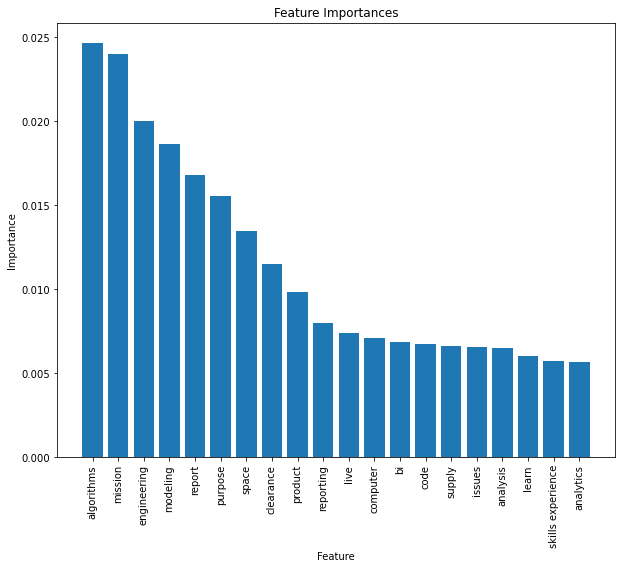

In [ ]:
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar chart of feature importances
plt.figure(figsize=(10,8))
plt.bar(range(20), importances[indices][:20])

# Add feature names as x-axis labels
plt.xticks(range(20), [tv.get_feature_names_out()[i] for i in indices][:20], rotation=90)

# Set axis labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Data Analyst


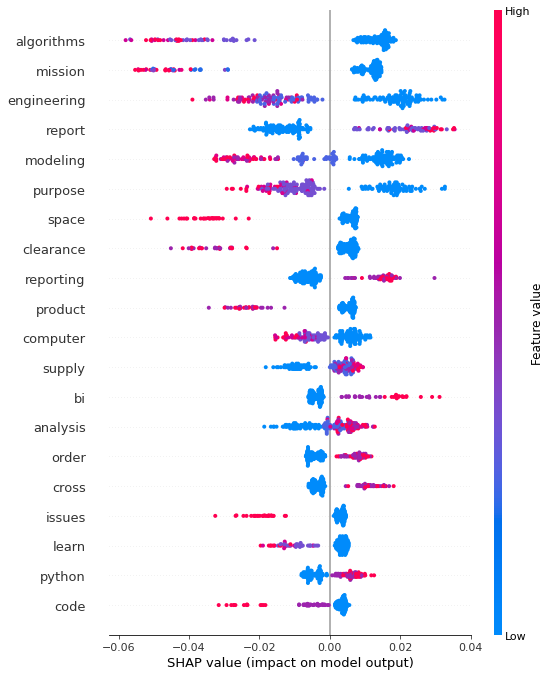

Data Scientist


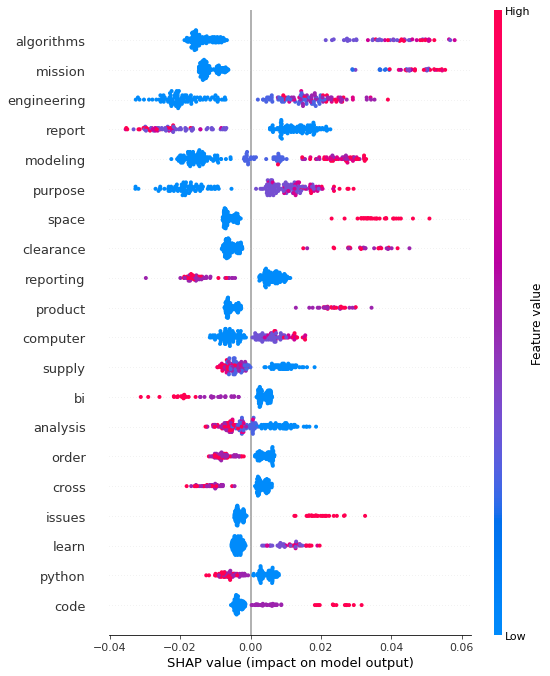

In [ ]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(train_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(train_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())

Data Analyst


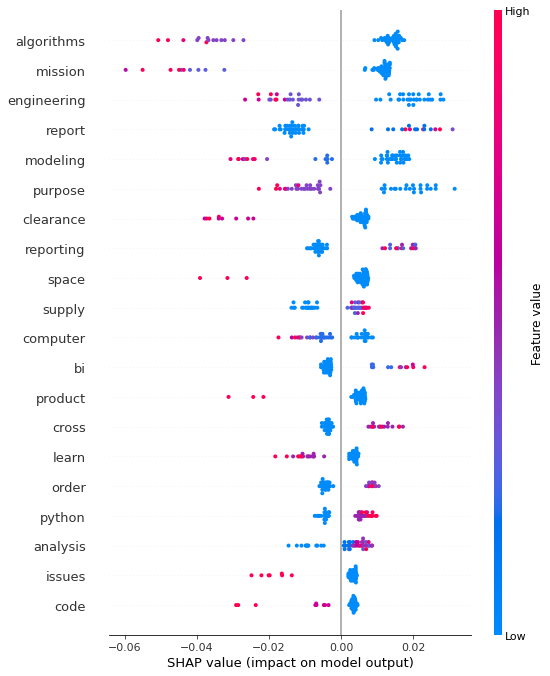

Data Scientist


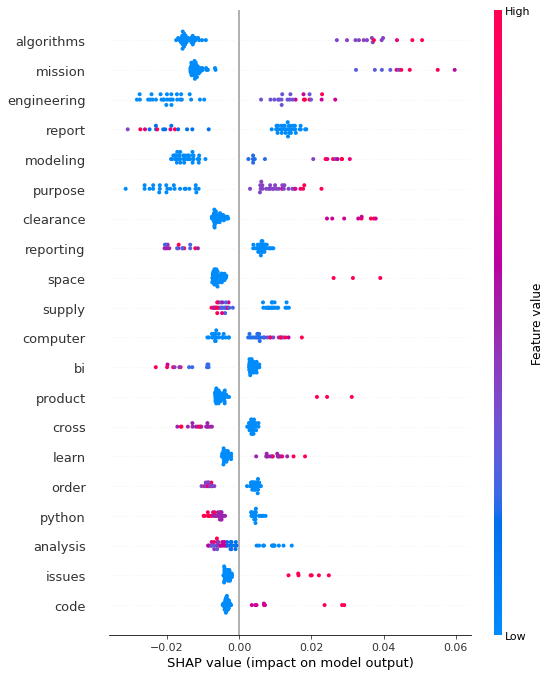

In [ ]:
# Calculate the Shapley values for each instance in the data set
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(test_tv.todense()))

# # Create a summary plot for the feature importances for each class
for i in range(clf.n_classes_):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], np.array(test_tv.todense()), class_names=clf.classes_[i],feature_names=tv.get_feature_names_out())